# Computing a simple alpha factor and its IC

21/12/2025

In this notebook I'll be handling data to calculate the 12 month momentum of different stocks as a possible alpha factor. The alpha factor could be defined as follows:

"The highest 12 month momentum stock will outperform the rest of stocks in the same universe in the next 21 days".

I'll be using the information coefficient to gauge the value of this alpha factor, which is explained below.

The Information Coefficient (IC) in finance measures an analyst's or model's forecasting skill by calculating the correlation between predicted returns and actual subsequent returns, helping to validate alpha models and manager performance. It's a key metric for assessing predictive power, showing how well rankings of stocks (e.g., "best to worst") align with their actual performance. 

### How it works
Calculation: It's typically a correlation coefficient (like Spearman's rank correlation) between the forecasted rankings or scores of assets and their actual realized returns over a period.

### Interpretation
+1: Perfect positive correlation (predictions consistently right).\
0: No correlation (no better than random guessing).\
-1: Perfect negative correlation (always predicts the opposite).

### Key applications
- Evaluating Alpha Models: Tests if a quantitative model's "alpha" (skill-based return) is reliable.
- Measuring Manager Skill: Assesses if a portfolio manager consistently picks winners.
- Portfolio Construction: Helps decide whether to rely more on strong signals (high IC) or a broader range of signals (breadth). 

In [18]:
import sys
sys.path.append(r"C:\Users\Sergio\Documents\GitHUb\Quant-trading-journey\src")
import quant_utils as qu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tickers = ['AAPL', 'TSLA', 'MSFT', 'NVDA', 'AVGO']
data = qu.data.download_data(tickers)

Saved → C:\Users\Sergio\Documents\GitHUb\Quant-trading-journey\src\data\AAPL_TSLA_MSFT_NVDA_AVGO_max_1d.pkl


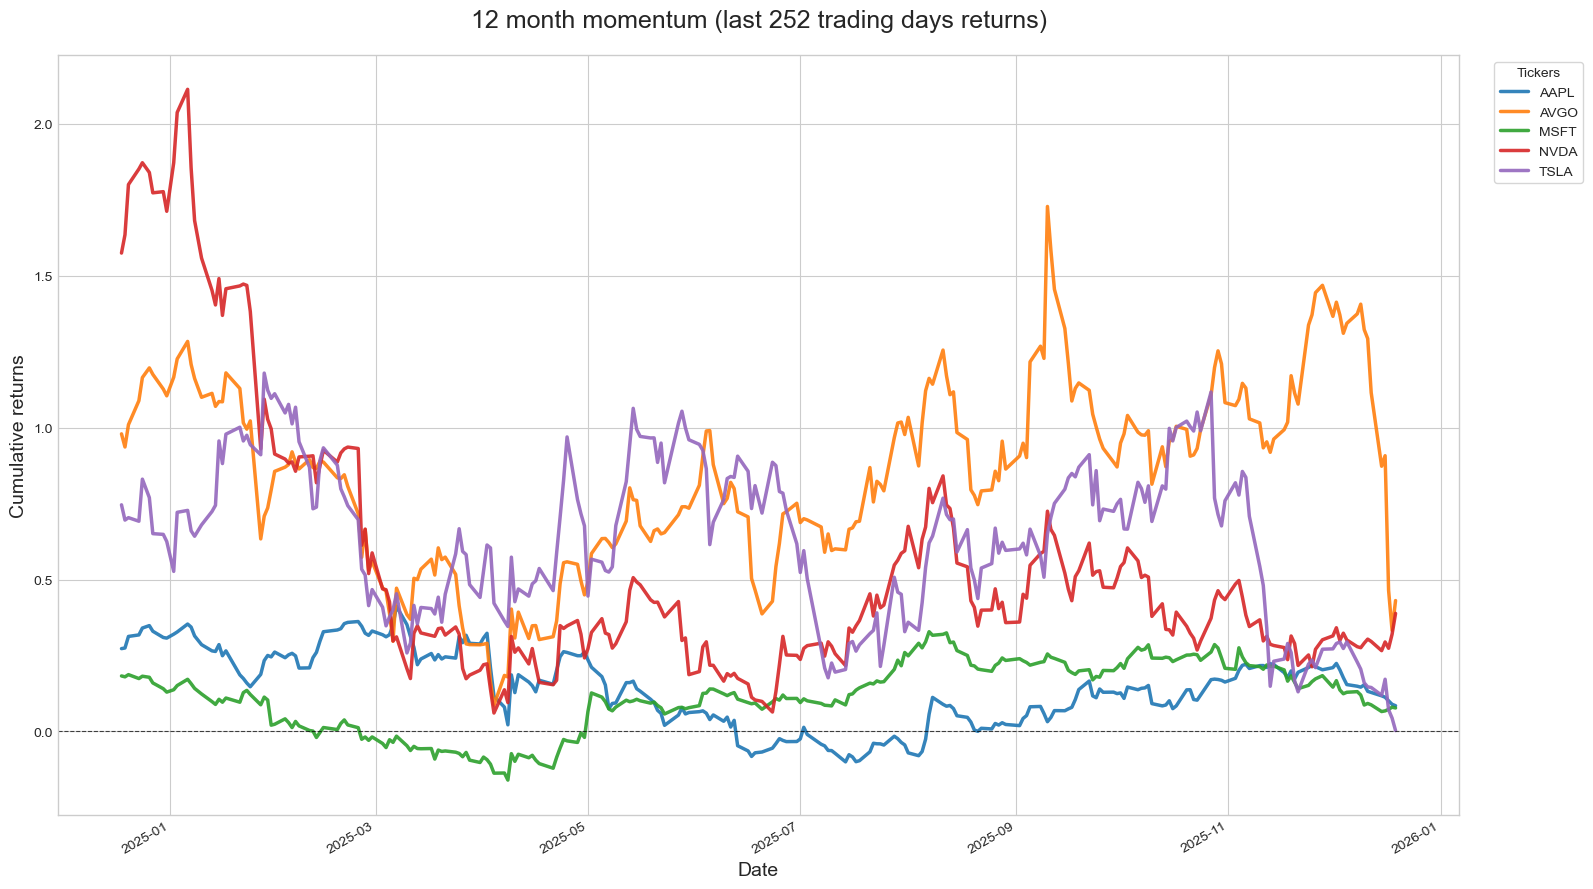

In [3]:
# Calculating rolling momentum for 12 months as alpha factor
n = 1 
days_per_year = 252 
rol_window = n * days_per_year

momentum = data.pct_change(periods=rol_window, fill_method=None)
momentum_last_year = momentum.tail(rol_window)

plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(16, 9))
momentum_last_year.plot(ax=ax, linewidth=2.5, alpha=0.9)

ax.set_title('12 month momentum (last 252 trading days returns)', fontsize=18, pad=20)
ax.set_ylabel('Cumulative returns', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.legend(title='Tickers', bbox_to_anchor=(1.02, 1), loc='upper left', frameon=True)

ax.axhline(0, color='black', linewidth=0.8, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Interpretation

This chart alone is not significant for trading purposes. 
As the principle states: "past returns do not guarantee future returns."

What this plot shows:
- Historical momentum patterns for each ticker
- Relative performance differences between stocks
- Periods of high/low momentum

What we DON'T know yet (and need to validate):
- Signal quality: How much is real signal vs noise?
- Signal persistence: How long does momentum predict future returns before decaying?
- Predictive power: Is there actual correlation between current momentum and forward returns?

To answer these questions, we'll calculate the Information Coefficient (IC) - 
the correlation between today's momentum and future returns at various horizons.

In [17]:
# Measuring Information Coefficient (IC)

from scipy.stats import spearmanr

# Preparing the dataframe
forward_horizon = 21
momentum = data.pct_change(252).shift(1).rank(pct=True, axis=1).dropna()
forward_returns = data.pct_change(forward_horizon).shift(-forward_horizon).rank(pct=True, axis=1).dropna()

# Cross-sectional comparison
ic_values = []
for i in range(len(momentum)):
    common = momentum.iloc[i].dropna().index.intersection(forward_returns.iloc[i].dropna().index)
    if len(common) >= 2:  # Mínimo para 5 tickers
        ic = spearmanr(momentum.iloc[i][common], forward_returns.iloc[i][common])[0]
        ic_values.append(ic)

ic_series = pd.Series(ic_values).dropna()

print(f"\n{'='*60}")
print("Information coefficient results")
print(f"{'='*60}")
print(f"Average IC: {ic_series.mean():.4f}")
print(f"Median IC: {ic_series.median():.4f}")
print(f"Std IC: {ic_series.std():.4f}")
print(f"T-stat: {ic_series.mean() / ic_series.std() * np.sqrt(len(ic_series)):.2f}")


Information coefficient results
Average IC: 0.2388
Median IC: 0.3000
Std IC: 0.5149
T-stat: 27.98


## Interpretation

An **average IC of 0.2388** indicates strong predictive ability. The factor has standalone utility in this small universe but requires validation with more assets.

A **median IC of 0.3000** higher than the mean confirms positively skewed distribution. Typical days show excellent predictive power, with occasional weaker correlation periods.

The **standard deviation of 0.5149** (~2x mean IC) reflects high noise due to small cross-sectional sample (5 tickers). With 50+ assets, IC would stabilize ~0.03-0.05 while maintaining significance.

The **t-statistic of 27.98** confirms extreme statistical significance (p << 0.001). We reject the null hypothesis with absolute confidence.

The very high IC is explained by the cherrypicking of the stocks, which not only have survived all along, nut exhibit strong persistent momentum 2015-2025. Moreover, the reduced number of stocks (5) further inflates IC.